In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.version

import yfinance as yf
yf.pdr_override()
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def get_stock(symbol, start, end):
    stocks = yf.download("SPY " + symbol, start, end)
    return stocks['Adj Close'][[symbol]]

In [3]:
def dollar_cost_avg_test(symbol, measured_days, step_size, trials = None):
    from collections import defaultdict
    import math

    assert isinstance(symbol, pd.DataFrame), "DataFrame is required for input"
    assert len(symbol.columns) == 1, "Can only support one symbol at a time."
    # assert isinstance(start_date, str)
    # assert isinstance(end_date, str)
    assert isinstance(measured_days, int)
    assert isinstance(step_size, int)

    #start and end dates need to be on a trading day
    start_date = '2012-01-06'
    end_date = '2021-01-29'
    max_end_date = str((symbol.index[len(symbol)-measured_days]).date())
    tests = defaultdict(list)

    if trials == None:
        print("Trials not specified. Using maximum allowed trials.")
        trials = math.floor((len(symbol)-measured_days)/step_size)
    elif trials > (len(symbol)-measured_days)/step_size:
        print("Trials exceed maximum allowed")
        trials = math.floor((len(symbol)-measured_days)/step_size)

    for i in range(0,trials):
        test = symbol.iloc[0+i*step_size:measured_days+i*step_size,0].reset_index().iloc[:,1]
        test = test/test[0] - 1
        tests[i] = test
    return pd.DataFrame(tests)

[*********************100%***********************]  2 of 2 completed
Trials not specified. Using maximum allowed trials.


<AxesSubplot:>

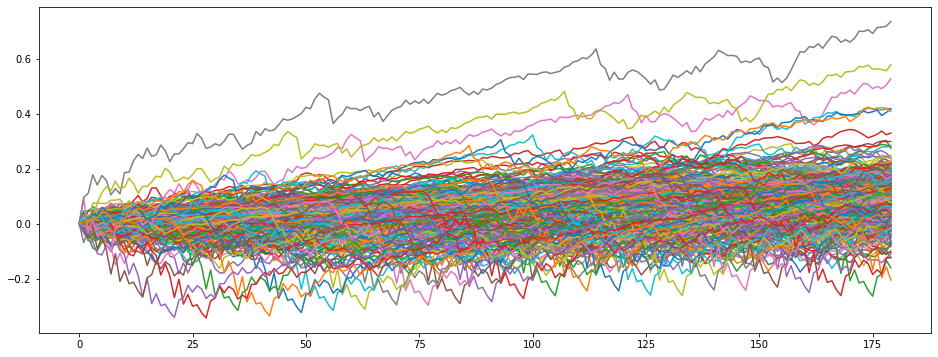

In [9]:
symbols = get_stock('VTI', '2010-01-06', '2021-01-29')
symbol = symbols.loc[symbols.first_valid_index():]
result = dollar_cost_avg_test(symbol = symbol,
    measured_days = 180,
    step_size = 7)
    
result.plot(figsize=(16,6), legend = False)

<AxesSubplot:>

0.0978351388546574

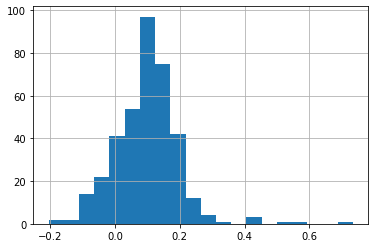

In [10]:
result.iloc[len(result)-1].hist(bins = 20)

result.iloc[len(result)-1].mean()